### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. It also requires functions I've written that are from my personal repo (https://github.com/patrickingraham/lsst_python_utils.git)

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [2]:
#Import CWFS package
#from lsst import cwfs

In [15]:
import numpy as np

import logging
logger = logging.getLogger('calc_CofM_logger')

def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    #just make it easier to understand below
    shape=array.shape
        
    # Should add tests to check bounds here
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [16]:
def make_circle(yxdims, radius, center=None):
    
    #dims is y,x dimensions
    
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't use transpose since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

(1500, 700)

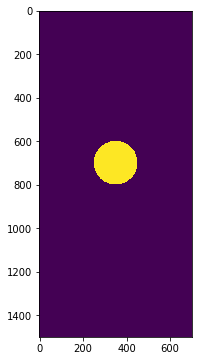

In [21]:
stamp=make_circle((1500,700), 100, center=(700,350))
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(stamp, interpolation='none')
stamp.shape

In [22]:
calc_CofM(stamp)

2019-09-09 00:02:55,249 calc_CofM_logger INFO     y_CofM is 700.0
2019-09-09 00:02:55,252 calc_CofM_logger INFO     x_CofM is 350.0


(700.0, 350.0)

In [68]:
data_folder = Path("/home/pingraham/tmp/doughnuts")

# # get list of files from a manually made txt file
# file_to_open = data_folder / "extra_focal_list.txt"
# tmp=file_to_open.read_text()
# extra_focal_fnames=tmp.split('\n')
# # Manual examination shows the first 10 are junk


# get list of files from a manually made txt file
file_to_open = data_folder / "extra_focal_list2.txt"
tmp=file_to_open.read_text()
extra_focal_fnames=tmp.split('\n')
for i,f in enumerate(extra_focal_fnames):
    extra_focal_fnames[i]+='.fits'


In [69]:
# get list of files from a manually made txt file
file_to_open = data_folder / "intra_focal_list.txt"
tmp=file_to_open.read_text()
intra_focal_fnames=tmp.split('\n')
for i,f in enumerate(extra_focal_fnames):
    intra_focal_fnames[i]+='.fits'
    


In [70]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [74]:
# read file into memory
#d1=extra_focal_fnames[0]
# align with other doughnut
bin_size=8

focal_fnames = intra_focal_fnames
#focal_fnames = extra_focal_fnames
img_size=(3520, 4656) # y,x
#center_of_ref=[img_size[1]-3750,img_size[0]-420] # y,x
center_of_ref=(900, 3180) #(900, 3200)
print('Center of image 0 is: {}'.format(center_of_ref))
side=None
side=300
focal_doughnut = np.empty((2*side, 2*side), dtype=float)

d=None; d0=None; d1=None
for i,fname in enumerate(focal_fnames[0:70]):
    
    with fits.open(data_folder / fname) as hdul0:
        # data is [y,x]
        d0=None
        
        #circle = make_circle(img_size, radius=20, center=(900,3080))
        #print('shape of circle: {}'.format(circle.shape))
        
        #raw_frame = circle
        raw_frame = hdul0[0].data
        
        d0=np.array((raw_frame[center_of_ref[0]-side:center_of_ref[0]+side, 
                        center_of_ref[1]-side:center_of_ref[1]+side]))
        
        #convert to float
        d0=copy.deepcopy(d0.astype(float))
        print('shape of d0: {}'.format(d0.shape))

        
        # subtract median background... which should do nothing
        d1= d0- np.median(d0)
        d1 = copy.deepcopy(d0)
        #d_full=hdul0[0].data
        
        #boxcar smooth to remove hot pixels

        d = None
        #d = ndimage.median_filter(d1, size=15)
        d = copy.deepcopy(d0)
        
        #d_binned = rebin(d, [int(d.shape[0]/bin_size), int(d.shape[1]/bin_size)])


        # Measure centroid (CofM)
        #corner=np.array(center_of_ref)-side
        #d_CofM = calc_CofM(d, corner) # y,x is 3179,923 (add y=20 gives 3160,923)
        #print('Corner coor d_CofM {}'.format(d_CofM))
        
        #now without the reference
        d_CofM = np.array(calc_CofM(d)) # y,x is 3179,923 (add y=20 gives 3160,923)
        print('No corner d_CofM as calculated {}'.format(d_CofM))
    
        yoffset_to_center_of_ref = (d_CofM[0]-side)
        xoffset_to_center_of_ref = (d_CofM[1]-side)
        print('yoffset: {}'.format(yoffset_to_center_of_ref))
        print('xoffset: {}'.format(xoffset_to_center_of_ref))
        
        new_center = np.array((center_of_ref[0]+yoffset_to_center_of_ref,
                     center_of_ref[1]+xoffset_to_center_of_ref), dtype=int)
        
        print('new center is: {}'.format(new_center))
        
        stamp=None
        stamp=np.array((raw_frame[new_center[0]-side:new_center[0]+side, 
                        new_center[1]-side:new_center[1]+side]))
        
        # Add it to the stack of doughnuts
        focal_doughnut+=stamp

        # Take the new center
        center_of_ref = copy.deepcopy(new_center)
        
        # for troubleshooting
        if i >= 5 and False: #7 is problematic
            mag=1
            print('Displaying image {}'.format(fname))
            #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
            #plt.imshow(d)
            
            fig, ax = plt.subplots(figsize=(7,6))

            ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
                                              #       center_of_ref[1]-side, 
                                              #       center_of_ref[0]+side,
                                              #       center_of_ref[0]-side])
            
            fig2, ax2 = plt.subplots(figsize=(7,6))

            ax2.imshow(stamp, interpolation='none')
            
            break
            # show full frame
            #fig, ax = plt.subplots(figsize=(7,6))
            #ax.imshow(d_full, interpolation='none')
            
            #break
            #ax.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        
        # 1325681292-AlfPsA-0-10.fits  = 883, 3212
        # 1325681293-AlfPsA-1-10.fits = 889, 3204
        # 1325681293-AlfPsA-2-10.fits = 794, 3262

2019-09-09 00:34:07,802 calc_CofM_logger INFO     y_CofM is 213.26798941899952
2019-09-09 00:34:07,817 calc_CofM_logger INFO     x_CofM is 485.48884722538855
2019-09-09 00:34:07,888 calc_CofM_logger INFO     y_CofM is 284.3173021451823
2019-09-09 00:34:07,894 calc_CofM_logger INFO     x_CofM is 343.77151837532


Center of image 0 is: (900, 3180)
shape of d0: (600, 600)
No corner d_CofM as calculated [213.26798942 485.48884723]
yoffset: -86.73201058100048
xoffset: 185.48884722538855
new center is: [ 813 3365]
shape of d0: (600, 600)
No corner d_CofM as calculated [284.31730215 343.77151838]
yoffset: -15.682697854817718
xoffset: 43.77151837532
new center is: [ 797 3408]
shape of d0: (600, 600)


2019-09-09 00:34:07,963 calc_CofM_logger INFO     y_CofM is 142.37347186219426
2019-09-09 00:34:07,966 calc_CofM_logger INFO     x_CofM is 438.82294452496717
2019-09-09 00:34:08,073 calc_CofM_logger INFO     y_CofM is 272.8104756457124
2019-09-09 00:34:08,092 calc_CofM_logger INFO     x_CofM is 313.8213223710822
2019-09-09 00:34:08,173 calc_CofM_logger INFO     y_CofM is 358.1206091282146


No corner d_CofM as calculated [142.37347186 438.82294452]
yoffset: -157.62652813780574
xoffset: 138.82294452496717
new center is: [ 639 3546]
shape of d0: (600, 600)
No corner d_CofM as calculated [272.81047565 313.82132237]
yoffset: -27.189524354287585
xoffset: 13.821322371082204
new center is: [ 611 3559]
shape of d0: (600, 600)


2019-09-09 00:34:08,186 calc_CofM_logger INFO     x_CofM is 262.8840928346653
2019-09-09 00:34:08,273 calc_CofM_logger INFO     y_CofM is 365.76922772548915
2019-09-09 00:34:08,282 calc_CofM_logger INFO     x_CofM is 237.23047095353473
2019-09-09 00:34:08,366 calc_CofM_logger INFO     y_CofM is 347.84546233380735
2019-09-09 00:34:08,372 calc_CofM_logger INFO     x_CofM is 263.9442057376478


No corner d_CofM as calculated [358.12060913 262.88409283]
yoffset: 58.120609128214596
xoffset: -37.115907165334704
new center is: [ 669 3521]
shape of d0: (600, 600)
No corner d_CofM as calculated [365.76922773 237.23047095]
yoffset: 65.76922772548915
xoffset: -62.769529046465266
new center is: [ 734 3458]
shape of d0: (600, 600)
No corner d_CofM as calculated [347.84546233 263.94420574]
yoffset: 47.84546233380735
xoffset: -36.05579426235221
new center is: [ 781 3421]


2019-09-09 00:34:08,519 calc_CofM_logger INFO     y_CofM is 324.240671015118
2019-09-09 00:34:08,526 calc_CofM_logger INFO     x_CofM is 290.57563930164105
2019-09-09 00:34:08,619 calc_CofM_logger INFO     y_CofM is 275.040065243133
2019-09-09 00:34:08,629 calc_CofM_logger INFO     x_CofM is 327.7314297257749
2019-09-09 00:34:08,701 calc_CofM_logger INFO     y_CofM is 123.31201255029522
2019-09-09 00:34:08,708 calc_CofM_logger INFO     x_CofM is 434.6003725423233


shape of d0: (600, 600)
No corner d_CofM as calculated [324.24067102 290.5756393 ]
yoffset: 24.240671015117982
xoffset: -9.424360698358953
new center is: [ 805 3411]
shape of d0: (600, 600)
No corner d_CofM as calculated [275.04006524 327.73142973]
yoffset: -24.95993475686703
xoffset: 27.731429725774888
new center is: [ 780 3438]
shape of d0: (600, 600)


2019-09-09 00:34:08,813 calc_CofM_logger INFO     y_CofM is 318.9172990416304
2019-09-09 00:34:08,821 calc_CofM_logger INFO     x_CofM is 284.034268262337


No corner d_CofM as calculated [123.31201255 434.60037254]
yoffset: -176.6879874497048
xoffset: 134.60037254232333
new center is: [ 603 3572]
shape of d0: (600, 600)
No corner d_CofM as calculated [318.91729904 284.03426826]
yoffset: 18.917299041630372
xoffset: -15.96573173766302
new center is: [ 621 3556]


2019-09-09 00:34:08,955 calc_CofM_logger INFO     y_CofM is 360.62396174747215
2019-09-09 00:34:08,965 calc_CofM_logger INFO     x_CofM is 251.79611615834145
2019-09-09 00:34:09,049 calc_CofM_logger INFO     y_CofM is 372.4988755025385
2019-09-09 00:34:09,056 calc_CofM_logger INFO     x_CofM is 242.0335190642804


shape of d0: (600, 600)
No corner d_CofM as calculated [360.62396175 251.79611616]
yoffset: 60.62396174747215
xoffset: -48.20388384165855
new center is: [ 681 3507]
shape of d0: (600, 600)
No corner d_CofM as calculated [372.4988755  242.03351906]
yoffset: 72.49887550253851
xoffset: -57.9664809357196
new center is: [ 753 3449]


2019-09-09 00:34:09,181 calc_CofM_logger INFO     y_CofM is 333.80340291581956
2019-09-09 00:34:09,183 calc_CofM_logger INFO     x_CofM is 266.62208632719904
2019-09-09 00:34:09,257 calc_CofM_logger INFO     y_CofM is 328.38413467849335
2019-09-09 00:34:09,263 calc_CofM_logger INFO     x_CofM is 295.25003521828177


shape of d0: (600, 600)
No corner d_CofM as calculated [333.80340292 266.62208633]
yoffset: 33.80340291581956
xoffset: -33.37791367280096
new center is: [ 786 3415]
shape of d0: (600, 600)
No corner d_CofM as calculated [328.38413468 295.25003522]
yoffset: 28.384134678493353
xoffset: -4.7499647817182336
new center is: [ 814 3410]


2019-09-09 00:34:09,419 calc_CofM_logger INFO     y_CofM is 211.9518570150325
2019-09-09 00:34:09,423 calc_CofM_logger INFO     x_CofM is 363.00780836630275
2019-09-09 00:34:09,515 calc_CofM_logger INFO     y_CofM is 180.2668387912414
2019-09-09 00:34:09,521 calc_CofM_logger INFO     x_CofM is 396.34893807560735
2019-09-09 00:34:09,600 calc_CofM_logger INFO     y_CofM is 340.3733742991531
2019-09-09 00:34:09,608 calc_CofM_logger INFO     x_CofM is 279.5216144882983


shape of d0: (600, 600)
No corner d_CofM as calculated [211.95185702 363.00780837]
yoffset: -88.04814298496751
xoffset: 63.007808366302754
new center is: [ 725 3473]
shape of d0: (600, 600)
No corner d_CofM as calculated [180.26683879 396.34893808]
yoffset: -119.73316120875859
xoffset: 96.34893807560735
new center is: [ 605 3569]
shape of d0: (600, 600)


2019-09-09 00:34:09,681 calc_CofM_logger INFO     y_CofM is 360.93300348832145
2019-09-09 00:34:09,684 calc_CofM_logger INFO     x_CofM is 246.6935286271581
2019-09-09 00:34:09,764 calc_CofM_logger INFO     y_CofM is 345.96791176347455
2019-09-09 00:34:09,766 calc_CofM_logger INFO     x_CofM is 250.32672562795253


No corner d_CofM as calculated [340.3733743  279.52161449]
yoffset: 40.37337429915311
xoffset: -20.478385511701674
new center is: [ 645 3548]
shape of d0: (600, 600)
No corner d_CofM as calculated [360.93300349 246.69352863]
yoffset: 60.93300348832145
xoffset: -53.30647137284191
new center is: [ 705 3494]
shape of d0: (600, 600)
No corner d_CofM as calculated [345.96791176 250.32672563]
yoffset: 45.96791176347455
xoffset: -49.67327437204747
new center is: [ 750 3444]


2019-09-09 00:34:09,873 calc_CofM_logger INFO     y_CofM is 337.732974702717
2019-09-09 00:34:09,886 calc_CofM_logger INFO     x_CofM is 270.8800751589883
2019-09-09 00:34:09,963 calc_CofM_logger INFO     y_CofM is 271.12641840310164
2019-09-09 00:34:09,967 calc_CofM_logger INFO     x_CofM is 316.1479131371757
2019-09-09 00:34:10,046 calc_CofM_logger INFO     y_CofM is 131.57410444575973
2019-09-09 00:34:10,050 calc_CofM_logger INFO     x_CofM is 461.5859522085899


shape of d0: (600, 600)
No corner d_CofM as calculated [337.7329747  270.88007516]
yoffset: 37.732974702717
xoffset: -29.11992484101171
new center is: [ 787 3414]
shape of d0: (600, 600)
No corner d_CofM as calculated [271.1264184  316.14791314]
yoffset: -28.87358159689836
xoffset: 16.147913137175692
new center is: [ 758 3430]
shape of d0: (600, 600)
No corner d_CofM as calculated [131.57410445 461.58595221]
yoffset: -168.42589555424027
xoffset: 161.5859522085899
new center is: [ 589 3591]


2019-09-09 00:34:10,134 calc_CofM_logger INFO     y_CofM is 318.8066590113319
2019-09-09 00:34:10,138 calc_CofM_logger INFO     x_CofM is 291.2388559838822
2019-09-09 00:34:10,215 calc_CofM_logger INFO     y_CofM is 363.2293274994931
2019-09-09 00:34:10,219 calc_CofM_logger INFO     x_CofM is 243.04645354514767
2019-09-09 00:34:10,299 calc_CofM_logger INFO     y_CofM is 368.56824543454525
2019-09-09 00:34:10,303 calc_CofM_logger INFO     x_CofM is 249.35094953762933


shape of d0: (600, 600)
No corner d_CofM as calculated [318.80665901 291.23885598]
yoffset: 18.806659011331874
xoffset: -8.761144016117782
new center is: [ 607 3582]
shape of d0: (600, 600)
No corner d_CofM as calculated [363.2293275  243.04645355]
yoffset: 63.22932749949308
xoffset: -56.95354645485233
new center is: [ 670 3525]
shape of d0: (600, 600)
No corner d_CofM as calculated [368.56824543 249.35094954]
yoffset: 68.56824543454525
xoffset: -50.64905046237067
new center is: [ 738 3474]


2019-09-09 00:34:10,429 calc_CofM_logger INFO     y_CofM is 333.0534382096514
2019-09-09 00:34:10,434 calc_CofM_logger INFO     x_CofM is 254.09170938533194
2019-09-09 00:34:10,507 calc_CofM_logger INFO     y_CofM is 318.552794176913
2019-09-09 00:34:10,512 calc_CofM_logger INFO     x_CofM is 302.90005863063146
2019-09-09 00:34:10,603 calc_CofM_logger INFO     y_CofM is 260.24885483203707


shape of d0: (600, 600)
No corner d_CofM as calculated [333.05343821 254.09170939]
yoffset: 33.053438209651404
xoffset: -45.90829061466806
new center is: [ 771 3428]
shape of d0: (600, 600)
No corner d_CofM as calculated [318.55279418 302.90005863]
yoffset: 18.552794176912982
xoffset: 2.900058630631463
new center is: [ 789 3430]
shape of d0: (600, 600)


2019-09-09 00:34:10,618 calc_CofM_logger INFO     x_CofM is 335.2659434359649
2019-09-09 00:34:10,754 calc_CofM_logger INFO     y_CofM is 140.2411924345307
2019-09-09 00:34:10,763 calc_CofM_logger INFO     x_CofM is 425.65800370964575


No corner d_CofM as calculated [260.24885483 335.26594344]
yoffset: -39.75114516796293
xoffset: 35.265943435964914
new center is: [ 749 3465]
shape of d0: (600, 600)
No corner d_CofM as calculated [140.24119243 425.65800371]
yoffset: -159.7588075654693
xoffset: 125.65800370964575
new center is: [ 589 3590]


2019-09-09 00:34:10,933 calc_CofM_logger INFO     y_CofM is 318.6493205950788
2019-09-09 00:34:10,940 calc_CofM_logger INFO     x_CofM is 287.8019099479889
2019-09-09 00:34:11,041 calc_CofM_logger INFO     y_CofM is 378.29607658695704
2019-09-09 00:34:11,045 calc_CofM_logger INFO     x_CofM is 235.52029034839933
2019-09-09 00:34:11,118 calc_CofM_logger INFO     y_CofM is 358.9245259095386
2019-09-09 00:34:11,120 calc_CofM_logger INFO     x_CofM is 257.8323936228815


shape of d0: (600, 600)
No corner d_CofM as calculated [318.6493206  287.80190995]
yoffset: 18.64932059507879
xoffset: -12.198090052011082
new center is: [ 607 3577]
shape of d0: (600, 600)
No corner d_CofM as calculated [378.29607659 235.52029035]
yoffset: 78.29607658695704
xoffset: -64.47970965160067
new center is: [ 685 3512]
shape of d0: (600, 600)
No corner d_CofM as calculated [358.92452591 257.83239362]
yoffset: 58.9245259095386
xoffset: -42.16760637711849
new center is: [ 743 3469]


2019-09-09 00:34:11,205 calc_CofM_logger INFO     y_CofM is 323.28436508740407
2019-09-09 00:34:11,209 calc_CofM_logger INFO     x_CofM is 273.23311479957124
2019-09-09 00:34:11,289 calc_CofM_logger INFO     y_CofM is 315.94051484104295
2019-09-09 00:34:11,293 calc_CofM_logger INFO     x_CofM is 297.2337315392039
2019-09-09 00:34:11,376 calc_CofM_logger INFO     y_CofM is 186.05766336538247
2019-09-09 00:34:11,385 calc_CofM_logger INFO     x_CofM is 407.22788724871873


shape of d0: (600, 600)
No corner d_CofM as calculated [323.28436509 273.2331148 ]
yoffset: 23.28436508740407
xoffset: -26.76688520042876
new center is: [ 766 3442]
shape of d0: (600, 600)
No corner d_CofM as calculated [315.94051484 297.23373154]
yoffset: 15.940514841042955
xoffset: -2.766268460796084
new center is: [ 781 3439]
shape of d0: (600, 600)
No corner d_CofM as calculated [186.05766337 407.22788725]
yoffset: -113.94233663461753
xoffset: 107.22788724871873
new center is: [ 667 3546]


2019-09-09 00:34:11,483 calc_CofM_logger INFO     y_CofM is 223.030928971525
2019-09-09 00:34:11,486 calc_CofM_logger INFO     x_CofM is 358.4384849181522
2019-09-09 00:34:11,571 calc_CofM_logger INFO     y_CofM is 352.3029284647908
2019-09-09 00:34:11,577 calc_CofM_logger INFO     x_CofM is 256.2638123253846
2019-09-09 00:34:11,661 calc_CofM_logger INFO     y_CofM is 358.2969026336205
2019-09-09 00:34:11,666 calc_CofM_logger INFO     x_CofM is 250.41348264930744


shape of d0: (600, 600)
No corner d_CofM as calculated [223.03092897 358.43848492]
yoffset: -76.96907102847501
xoffset: 58.4384849181522
new center is: [ 590 3604]
shape of d0: (600, 600)
No corner d_CofM as calculated [352.30292846 256.26381233]
yoffset: 52.302928464790796
xoffset: -43.736187674615394
new center is: [ 642 3560]
shape of d0: (600, 600)
No corner d_CofM as calculated [358.29690263 250.41348265]
yoffset: 58.296902633620505
xoffset: -49.58651735069256
new center is: [ 700 3510]


2019-09-09 00:34:11,741 calc_CofM_logger INFO     y_CofM is 357.22230552995853
2019-09-09 00:34:11,744 calc_CofM_logger INFO     x_CofM is 265.4822513039616
2019-09-09 00:34:11,857 calc_CofM_logger INFO     y_CofM is 316.0716576276723
2019-09-09 00:34:11,861 calc_CofM_logger INFO     x_CofM is 270.7569613889244
2019-09-09 00:34:11,936 calc_CofM_logger INFO     y_CofM is 283.33724183245374


shape of d0: (600, 600)
No corner d_CofM as calculated [357.22230553 265.4822513 ]
yoffset: 57.22230552995853
xoffset: -34.51774869603838
new center is: [ 757 3475]
shape of d0: (600, 600)
No corner d_CofM as calculated [316.07165763 270.75696139]
yoffset: 16.071657627672323
xoffset: -29.243038611075576
new center is: [ 773 3445]
shape of d0: (600, 600)


2019-09-09 00:34:11,946 calc_CofM_logger INFO     x_CofM is 318.07922447778856
2019-09-09 00:34:12,032 calc_CofM_logger INFO     y_CofM is 122.22432787611086
2019-09-09 00:34:12,037 calc_CofM_logger INFO     x_CofM is 453.12345455753194
2019-09-09 00:34:12,121 calc_CofM_logger INFO     y_CofM is 306.1757579225703
2019-09-09 00:34:12,126 calc_CofM_logger INFO     x_CofM is 269.97568508044714


No corner d_CofM as calculated [283.33724183 318.07922448]
yoffset: -16.662758167546258
xoffset: 18.079224477788557
new center is: [ 756 3463]
shape of d0: (600, 600)
No corner d_CofM as calculated [122.22432788 453.12345456]
yoffset: -177.77567212388914
xoffset: 153.12345455753194
new center is: [ 578 3616]
shape of d0: (600, 600)
No corner d_CofM as calculated [306.17575792 269.97568508]
yoffset: 6.1757579225703125
xoffset: -30.024314919552864
new center is: [ 584 3585]


2019-09-09 00:34:12,203 calc_CofM_logger INFO     y_CofM is 372.20477692386316
2019-09-09 00:34:12,205 calc_CofM_logger INFO     x_CofM is 250.39705399565014
2019-09-09 00:34:12,310 calc_CofM_logger INFO     y_CofM is 370.5189033327521
2019-09-09 00:34:12,314 calc_CofM_logger INFO     x_CofM is 246.18008461071926


shape of d0: (600, 600)
No corner d_CofM as calculated [372.20477692 250.397054  ]
yoffset: 72.20477692386316
xoffset: -49.60294600434986
new center is: [ 656 3535]
shape of d0: (600, 600)
No corner d_CofM as calculated [370.51890333 246.18008461]
yoffset: 70.51890333275207
xoffset: -53.81991538928074
new center is: [ 726 3481]
shape of d0: (600, 600)


2019-09-09 00:34:12,404 calc_CofM_logger INFO     y_CofM is 333.67609464333685
2019-09-09 00:34:12,414 calc_CofM_logger INFO     x_CofM is 279.6615679665068
2019-09-09 00:34:12,488 calc_CofM_logger INFO     y_CofM is 317.2451981668981
2019-09-09 00:34:12,493 calc_CofM_logger INFO     x_CofM is 290.26687278177354
2019-09-09 00:34:12,557 calc_CofM_logger INFO     y_CofM is 260.15081913268
2019-09-09 00:34:12,561 calc_CofM_logger INFO     x_CofM is 317.6247621128662


No corner d_CofM as calculated [333.67609464 279.66156797]
yoffset: 33.67609464333685
xoffset: -20.338432033493177
new center is: [ 759 3460]
shape of d0: (600, 600)
No corner d_CofM as calculated [317.24519817 290.26687278]
yoffset: 17.245198166898092
xoffset: -9.733127218226457
new center is: [ 776 3450]
shape of d0: (600, 600)
No corner d_CofM as calculated [260.15081913 317.62476211]
yoffset: -39.84918086732
xoffset: 17.62476211286622
new center is: [ 736 3467]


2019-09-09 00:34:12,681 calc_CofM_logger INFO     y_CofM is 127.79105350172674
2019-09-09 00:34:12,685 calc_CofM_logger INFO     x_CofM is 458.63410100582604
2019-09-09 00:34:12,752 calc_CofM_logger INFO     y_CofM is 330.29508455688807
2019-09-09 00:34:12,757 calc_CofM_logger INFO     x_CofM is 260.9447434593142
2019-09-09 00:34:12,853 calc_CofM_logger INFO     y_CofM is 371.1460100477084
2019-09-09 00:34:12,855 calc_CofM_logger INFO     x_CofM is 246.3762595801844


shape of d0: (600, 600)
No corner d_CofM as calculated [127.7910535  458.63410101]
yoffset: -172.20894649827326
xoffset: 158.63410100582604
new center is: [ 563 3625]
shape of d0: (600, 600)
No corner d_CofM as calculated [330.29508456 260.94474346]
yoffset: 30.29508455688807
xoffset: -39.055256540685775
new center is: [ 593 3585]
shape of d0: (600, 600)
No corner d_CofM as calculated [371.14601005 246.37625958]
yoffset: 71.14601004770839
xoffset: -53.62374041981559
new center is: [ 664 3531]


2019-09-09 00:34:12,973 calc_CofM_logger INFO     y_CofM is 365.415469349325
2019-09-09 00:34:12,978 calc_CofM_logger INFO     x_CofM is 249.1527325304652
2019-09-09 00:34:13,081 calc_CofM_logger INFO     y_CofM is 327.03577269117903
2019-09-09 00:34:13,099 calc_CofM_logger INFO     x_CofM is 281.04889811329537


shape of d0: (600, 600)
No corner d_CofM as calculated [365.41546935 249.15273253]
yoffset: 65.41546934932501
xoffset: -50.84726746953481
new center is: [ 729 3480]
shape of d0: (600, 600)
No corner d_CofM as calculated [327.03577269 281.04889811]
yoffset: 27.035772691179034
xoffset: -18.951101886704635
new center is: [ 756 3461]


2019-09-09 00:34:13,218 calc_CofM_logger INFO     y_CofM is 286.6538639282317
2019-09-09 00:34:13,223 calc_CofM_logger INFO     x_CofM is 310.0757263036242
2019-09-09 00:34:13,311 calc_CofM_logger INFO     y_CofM is 196.15147997913323
2019-09-09 00:34:13,315 calc_CofM_logger INFO     x_CofM is 398.5988891345687
2019-09-09 00:34:13,384 calc_CofM_logger INFO     y_CofM is 231.55479743875262
2019-09-09 00:34:13,388 calc_CofM_logger INFO     x_CofM is 351.0371503692428


shape of d0: (600, 600)
No corner d_CofM as calculated [286.65386393 310.0757263 ]
yoffset: -13.346136071768285
xoffset: 10.075726303624208
new center is: [ 742 3471]
shape of d0: (600, 600)
No corner d_CofM as calculated [196.15147998 398.59888913]
yoffset: -103.84852002086677
xoffset: 98.59888913456871
new center is: [ 638 3569]
shape of d0: (600, 600)
No corner d_CofM as calculated [231.55479744 351.03715037]
yoffset: -68.44520256124738
xoffset: 51.037150369242795
new center is: [ 569 3620]


2019-09-09 00:34:13,466 calc_CofM_logger INFO     y_CofM is 348.27143046082176
2019-09-09 00:34:13,470 calc_CofM_logger INFO     x_CofM is 256.2806766602741
2019-09-09 00:34:13,556 calc_CofM_logger INFO     y_CofM is 379.0521433351486
2019-09-09 00:34:13,563 calc_CofM_logger INFO     x_CofM is 248.6603244559079


shape of d0: (600, 600)
No corner d_CofM as calculated [348.27143046 256.28067666]
yoffset: 48.27143046082176
xoffset: -43.71932333972592
new center is: [ 617 3576]
shape of d0: (600, 600)
No corner d_CofM as calculated [379.05214334 248.66032446]
yoffset: 79.05214333514863
xoffset: -51.3396755440921
new center is: [ 696 3524]


2019-09-09 00:34:13,684 calc_CofM_logger INFO     y_CofM is 343.13510366954534
2019-09-09 00:34:13,687 calc_CofM_logger INFO     x_CofM is 276.72013457156197
2019-09-09 00:34:13,763 calc_CofM_logger INFO     y_CofM is 330.7730509271428
2019-09-09 00:34:13,767 calc_CofM_logger INFO     x_CofM is 265.76836396081706
2019-09-09 00:34:13,848 calc_CofM_logger INFO     y_CofM is 280.59377360462406
2019-09-09 00:34:13,853 calc_CofM_logger INFO     x_CofM is 310.02423646148776


shape of d0: (600, 600)
No corner d_CofM as calculated [343.13510367 276.72013457]
yoffset: 43.135103669545344
xoffset: -23.27986542843803
new center is: [ 739 3500]
shape of d0: (600, 600)
No corner d_CofM as calculated [330.77305093 265.76836396]
yoffset: 30.773050927142776
xoffset: -34.231636039182945
new center is: [ 769 3465]
shape of d0: (600, 600)
No corner d_CofM as calculated [280.5937736  310.02423646]
yoffset: -19.40622639537594
xoffset: 10.02423646148776
new center is: [ 749 3475]


2019-09-09 00:34:13,940 calc_CofM_logger INFO     y_CofM is 126.99977688131854
2019-09-09 00:34:13,948 calc_CofM_logger INFO     x_CofM is 453.11039550730015
2019-09-09 00:34:14,021 calc_CofM_logger INFO     y_CofM is 296.9292616167817
2019-09-09 00:34:14,025 calc_CofM_logger INFO     x_CofM is 300.2602166561699
2019-09-09 00:34:14,115 calc_CofM_logger INFO     y_CofM is 375.234759969134
2019-09-09 00:34:14,119 calc_CofM_logger INFO     x_CofM is 237.18245678074697


shape of d0: (600, 600)
No corner d_CofM as calculated [126.99977688 453.11039551]
yoffset: -173.00022311868145
xoffset: 153.11039550730015
new center is: [ 575 3628]
shape of d0: (600, 600)
No corner d_CofM as calculated [296.92926162 300.26021666]
yoffset: -3.070738383218327
xoffset: 0.2602166561699164
new center is: [ 571 3628]
shape of d0: (600, 600)
No corner d_CofM as calculated [375.23475997 237.18245678]
yoffset: 75.23475996913402
xoffset: -62.817543219253025
new center is: [ 646 3565]


2019-09-09 00:34:14,220 calc_CofM_logger INFO     y_CofM is 372.3945687703487
2019-09-09 00:34:14,225 calc_CofM_logger INFO     x_CofM is 240.80234830795177
2019-09-09 00:34:14,294 calc_CofM_logger INFO     y_CofM is 340.9716434268196
2019-09-09 00:34:14,298 calc_CofM_logger INFO     x_CofM is 277.82433063263943
2019-09-09 00:34:14,370 calc_CofM_logger INFO     y_CofM is 309.8355577722839
2019-09-09 00:34:14,374 calc_CofM_logger INFO     x_CofM is 276.0968199276383


shape of d0: (600, 600)
No corner d_CofM as calculated [372.39456877 240.80234831]
yoffset: 72.39456877034871
xoffset: -59.197651692048225
new center is: [ 718 3505]
shape of d0: (600, 600)
No corner d_CofM as calculated [340.97164343 277.82433063]
yoffset: 40.97164342681958
xoffset: -22.17566936736057
new center is: [ 758 3482]
shape of d0: (600, 600)
No corner d_CofM as calculated [309.83555777 276.09681993]
yoffset: 9.835557772283892
xoffset: -23.903180072361693
new center is: [ 767 3458]


2019-09-09 00:34:14,478 calc_CofM_logger INFO     y_CofM is 273.45884953630747
2019-09-09 00:34:14,482 calc_CofM_logger INFO     x_CofM is 335.92871374869304
2019-09-09 00:34:14,548 calc_CofM_logger INFO     y_CofM is 134.53895208758343
2019-09-09 00:34:14,552 calc_CofM_logger INFO     x_CofM is 448.1051326813218


shape of d0: (600, 600)
No corner d_CofM as calculated [273.45884954 335.92871375]
yoffset: -26.54115046369253
xoffset: 35.92871374869304
new center is: [ 740 3493]
shape of d0: (600, 600)
No corner d_CofM as calculated [134.53895209 448.10513268]
yoffset: -165.46104791241657
xoffset: 148.10513268132178
new center is: [ 574 3641]


In [66]:
hdu = fits.PrimaryHDU(focal_doughnut)
hdul = fits.HDUList([hdu])
hdul.writeto('/home/pingraham/tmp/I1_intra_20190908.fits', overwrite=False)


In [73]:
hdu2 = fits.PrimaryHDU(stamp)
hdul2 = fits.HDUList([hdu2])
hdul2.writeto('/home/pingraham/tmp/I2_extra_20190908.fits', overwrite=True)

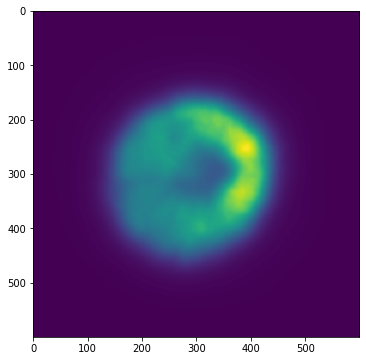

In [75]:
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(focal_doughnut, interpolation='none')

In [ ]:
# # try cross correlation
# # read file into memory
# #d1=extra_focal_fnames[0]
# # align with other doughnut
# bin_size=8
# i=1
# img_size=(3520, 4656) # y,x
# #center_of_ref=[img_size[1]-3750,img_size[0]-420] # y,x
# center_of_ref=(900, 3180) #(900, 3200)
# print('Center of image 0 is: {}'.format(center_of_ref))
# side=300
# extra_focal_doughnut = np.empty((2*side, 2*side), dtype=float)

# for i,fname in enumerate(extra_focal_fnames[0:2]):
    
#     with fits.open(data_folder / fname) as hdul0:
#         # data is [y,x]
#         d=np.array(hdul0[0].data[center_of_ref[0]-side:center_of_ref[0]+side, 
#                         center_of_ref[1]-side:center_of_ref[1]+side])
#         #convert to float
#         d=d.astype(float)
#         # subtract median background... which should do nothing
#         d-= np.median(d)
#         #d_full=hdul0[0].data
        
        
#         #d_binned = rebin(d, [int(d.shape[0]/bin_size), int(d.shape[1]/bin_size)])


#         # Measure cross correlation
#         if i != 0:
#             from scipy import signal
#             from scipy import misc

#             corr = signal.correlate2d(d, stamp, boundary='fill', mode='same',
#                                      fillvalue=np.median(d))
#             y, x = np.unravel_index(np.argmax(corr), corr.shape) # find the match
        
        
#         stamp=np.array(hdul0[0].data[center_of_ref[0]-side:center_of_ref[0]+side, 
#                         center_of_ref[1]-side:center_of_ref[1]+side])
        
#         extra_focal_doughnut+=stamp

#         if True:
#             mag=1
#             print('Displaying image {}'.format(fname))
#             #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
#             #plt.imshow(d)
            
#             fig, ax = plt.subplots(figsize=(7,6))

#             ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
#                                               #       center_of_ref[1]-side, 
#                                               #       center_of_ref[0]+side,
#                                               #       center_of_ref[0]-side])
            
#             fig, ax = plt.subplots(figsize=(7,6))

#             ax.imshow(stamp, interpolation='none')
            
#             # show full frame
#             #fig, ax = plt.subplots(figsize=(7,6))
#             #ax.imshow(d_full, interpolation='none')
            
#             #break
#             #ax.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        
#         # 1325681292-AlfPsA-0-10.fits  = 883, 3212
#         # 1325681293-AlfPsA-1-10.fits = 889, 3204
#         # 1325681293-AlfPsA-2-10.fits = 794, 3262

In [ ]:
corr

In [ ]:
d = salobj.Domain()
ATArchiver = salobj.Remote(d, 'ATArchiver')
await ATArchiver.start_task
ATCamera = salobj.Remote(d, 'ATCamera')
await ATCamera.start_task
#ATMonochromator = salobj.Remote(SALPY_ATMonochromator)
LinearStage1 = salobj.Remote(d, 'LinearStage',1)
await LinearStage1.start_task

### Leave this cell for state transitions 

In [ ]:
#  bring into enable state if required
if True:
    try:
        await LinearStage1.cmd_enable.start(timeout=5)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')
#asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

## Setup the Linear Stage (focuser)

In [ ]:
pos=None
pos=await LinearStage1.tel_position.next(flush=True, timeout=5)
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

In [ ]:
# Home the stage (only necessary if power was off)
if True:
    try:
        await LinearStage1.cmd_getHome.start(timeout=20)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')

In [ ]:
# Move the stage to desired position
lin_stage_pos=0.0 #33
LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
try:
    asyncio.get_event_loop().run_until_complete(LinearStage1.cmd_moveAbsolute.start())
except salobj.AckError as ack_err:
    print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")

In [ ]:
# Create details for intra/extra focal image focus offsets
wavelength=455
focus_center=33.85 # for 632nm no filter, no grating
focus_center = 27.5 # for 455nm no filter, no grating

dx=27.0
focus_demands = np.array((focus_center-dx, focus_center, focus_center+dx))
#focus_vals = np.arange(68.4, 71.3, 0.3) - coarse
print(focus_demands)

In [ ]:
# Get images 
image_list=[]
focus_vals=np.empty(len(focus_demands))
for i,lin_stage_pos in enumerate(focus_demands):
    #print('Beginning sweep at focus {} [mm]'.format(lin_stage_pos))
    
    # Move focus stage
    LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
    try:
        await LinearStage1.cmd_moveAbsolute.start()
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
    
    # shouldn't have to do this but sometimes it pulls the wrong value, need to look into this
    # will test when new version is released (imminent)
    await asyncio.sleep(3.0)
    focus_vals[i]=(await LinearStage1.tel_position.next(flush=True, timeout=5)).position
    print('Linear stage demand {}, actual {}:'.format(lin_stage_pos, focus_vals[i]))
    
    # Take image with appropriate exposure times
    group_id='Focus,wavelength = {},{}'.format(str(lin_stage_pos), str(wavelength))
    #exptime=0.2 for 632 laser with ND4
    #exptime=5 for 455nm LED ND3, but focused images saturates
    if i != 1:
        expTime = 5 # out of focus expTime
    else:
        expTime = 0.5
    
    ATCamera.cmd_takeImages.set(expTime=expTime, shutter=1, numImages=1, imageSequenceName=group_id)
    ATCamera.evt_endReadout.flush()
    try:
        await ATCamera.cmd_takeImages.start()
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")

    endReadout = await ATCamera.evt_endReadout.next(flush=False, timeout=30)
    print('Wrote file {}'.format(endReadout.imageName) )
    
    image_list.append(endReadout.imageName)

In [ ]:
for index, img in enumerate(image_list):
    print('{}, {:0.2f}'.format(img, focus_vals[index]))

In [ ]:
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure


import utils.grabATImage 
importlib.reload(utils.grabATImage)
from utils.grabATImage import grabATImage

In [ ]:
# parse out visitID from filename - this is highly annoying
tmp=endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
visitID = int((prefix+suffix))
dataId1 = {'visit': visitID}
print(visitID)

# Grab image from butler, but need to wait to ingestion so use this polling function
exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)

# do ISR correction
isr_corr_exposure = processExposure(exposure, repo=repo)

In [ ]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

In [ ]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

In [ ]:
# I don't like looping but apparently there is no way to reduce multiple files from a notebook
# Declare approximation of where the zero-order star is
zeroth_order_estimate = lsst.geom.Point2D(1700,1960)
zeroth_order_estimate = lsst.geom.Point2D(2075,2025) # low res grating
zeroth_order_estimate = lsst.geom.Point2D(2260,2050) #empty (632)
zeroth_order_estimate = lsst.geom.Point2D(2090,2220) #empty (455)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(200,200)) 

fit_data=[]
visitIDs=[]

for index, img_name in enumerate(image_list):
    # parse out visitID from filename - this is highly annoying
    print('Processing file {} of {}, filename={}'.format(index,len(image_list), img_name))
    tmp=img_name.split('_')
    prefix=tmp[2] # dayobs without the dashes
    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    visitIDs.append(visitID)
    #dataId1 = {'visit': visitID}
    #multi_file_dataset[i]['visitID']=visitID
    
    # Doing this if the source finding is failing
    # 
    
    continue
    
    #exposure = butler.get('raw', **dataId1)
    exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)
    # do ISR correction
    isr_corr_exposure = processExposure(exposure, repo=repo, defects=None) #bias=None
    
    # Find all sources in the image
    tab = afwTable.SourceTable.make(schema)
    # Find the correct sources using just a strip
    search_center_pt = lsst.geom.Point2D(zeroth_order_estimate.getX(),2000)
    search_strip = lsst.geom.Box2I.makeCenteredBox(search_center_pt, lsst.geom.Extent2I(500,3999)) 
    result = sourceDetectionTask.run(tab, isr_corr_exposure[search_strip], sigma=15.0)
    
    # wavelength solution is bad for the fiberSpectrograph, but close enough for this to work
    # can use the monochromator wavelength which is better, but that's not the correct way in the long run

    if True: # display the image in firefly
        plt.close('all')
        disp = afwDisplay.Display(2, reopenPlot=True)
        disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
        disp.setImageColormap('gray')
        disp.scale('linear', 'minmax')
        peak0_subim = isr_corr_exposure.subset(zeroth_order_star_BBox)
        disp.mtv(peak0_subim, title='visit = {}'.format(visitID))        
        #disp.scale('linear', 'zscale')
        #disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
        #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
        break
        
    
    dispersion = (1/0.6358) # pixels/nm
    spectral_position_angle=0.0107 # radians clockwise from top

    # Find 0th and +/- 1 order peaks 
    sources = result.sources
    dispersion=None
    center_source = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
#    center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
    
    # Fit peaks
    # zeroth order
    # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names
    
    bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(190,190)) 
    peak0_subim = isr_corr_exposure.subset(bbox0)
    p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
    p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
    p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
    fit_data.append(p0_EE_rad80_pix)

#     # offset to test
#     bbox1 = lsst.geom.Box2I.makeCenteredBox(peak1.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak1_subim = isr_corr_exposure.subset(bbox1)
#     p1, x1 , y1 = fit2DGaussian(peak1_subim, plot=True)
#     p1_x_CofM, p1_y_CofM = calc_CofM(peak1_subim) # 2167,3372
#     fit_data.append(p1_EE_rad67_pix)


In [ ]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [ ]:
# Can declare visit IDs if you want to use old data
# visitIDs=[2019090400066, 2019090400067, 2019090400068]

In [ ]:
# get images 
intra_exposure = await grabATImage(visitIDs[0], repo, timeout = 40, poll_freq_hz=2)
focus_exposure = await grabATImage(visitIDs[1], repo, timeout = 40, poll_freq_hz=2)
extra_exposure = await grabATImage(visitIDs[2], repo, timeout = 40, poll_freq_hz=2)
isr_corr_exposure_intra = processExposure(intra_exposure, repo=repo, defects=None) #bias=None
isr_corr_exposure_focus = processExposure(focus_exposure, repo=repo, defects=None) #bias=None
isr_corr_exposure_extra = processExposure(extra_exposure, repo=repo, defects=None) #bias=None

In [ ]:
focus_center = lsst.geom.Point2D(2110,2250)
intra_center = lsst.geom.Point2D(2090,2280)
extra_center=lsst.geom.Point2D(2130,2230) ; 
bbox_focus= lsst.geom.Box2I.makeCenteredBox(focus_center, lsst.geom.Extent2I(160,160))
bbox_intra= lsst.geom.Box2I.makeCenteredBox(intra_center, lsst.geom.Extent2I(160,160))
bbox_extra= lsst.geom.Box2I.makeCenteredBox(extra_center, lsst.geom.Extent2I(160,160))


In [ ]:
fieldXY = [0.0,0.0]
I_focus = Image(isr_corr_exposure_focus.subset(bbox_focus).image.array, fieldXY, Image.EXTRA)
I1 = Image(isr_corr_exposure_intra.subset(bbox_intra).image.array, fieldXY, Image.INTRA)
I2 = Image(isr_corr_exposure_extra.subset(bbox_extra).image.array, fieldXY, Image.EXTRA)

In [ ]:
hdu = fits.PrimaryHDU(isr_corr_exposure_intra.subset(bbox_intra).image.array)
hdul = fits.HDUList([hdu])
hdul.writeto('/home/saluser/develop/I1_intra.fits', overwrite=True)
hdu2 = fits.PrimaryHDU(isr_corr_exposure_extra.subset(bbox_extra).image.array)
hdul2 = fits.HDUList([hdu2])
hdul2.writeto('/home/saluser/develop/I2_extra.fits', overwrite=True)

In [ ]:
plots.plotImage(I1.image,'intra')
plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [ ]:
# declare instrument - example
#inst=Instrument('lsst',I1.sizeinPix) # example

In [ ]:
inst=Instrument('auxtel_simulator',I1.sizeinPix) # example

In [ ]:
# declare algorithm - exponential
algo=Algorithm('exp',inst,1) # example

In [ ]:
algo.runIt(inst,I1,I2,'paraxial')

In [ ]:
# run it - example
#algo.runIt(inst,I1,I2,'offAxis')

In [ ]:
#print zernikes
print(algo.zer4UpNm)

In [ ]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')


In [ ]:
plots.plotImage(algo.Wconverge,'Final wavefront')

In [ ]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

In [ ]:
# Basic math to estimate the expected result
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))